In [0]:
!pip install -q seaborn

In [0]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-67pwrb51
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-67pwrb51
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.09c767b21ec238bb0fe8561f6596f5dcdce915c4e_-cp36-none-any.whl size=100470 sha256=14b25b0bfd0636c6439a3aef466f2e4acd6744b522a2bff99b086ea325609734
  Stored in directory: /tmp/pip-ephem-wheel-cache-ge4zz2d4/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import torch
import torch.nn as nn
import torch.utils.data as Data

import math
import matplotlib.pyplot as plt

In [0]:
# normalize data
def norm(x, summ_stat):
  return (x - summ_stat['mean'].astype(object)) / summ_stat['std'].astype(object)

In [0]:
# cleaning data
df = pd.read_csv("dataset.csv")
df = df.drop(['country', 'country_abb'], axis=1)
drop_row_indices = []
for i, row in df.iterrows():
    for j, col in row.iteritems():
        try:
            row[j] = float(col)
        except ValueError:
            # print("ValueError")
            drop_row_indices.append(i)
            continue
        if math.isnan(row[j]):
            drop_row_indices.append(i)
df = df.drop(drop_row_indices, axis = 0)
GDP_growth=df['GDPgrowth']

features = ['year','VAA', 'PSNV', 'GE', 'RQ', 'RL', 'CC', 'Tier0', 'Tier1', 'Tier2', 'GDPgrowth']

df = df.loc[:,features].astype(float)


In [0]:
#NN Model 1

train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

train_dataset.head()



,year,VAA,PSNV,GE,RQ,RL,CC,Tier0,Tier1,Tier2,GDPgrowth
1321,2008.0,-0.30,-0.16,-0.23,-0.35,-0.18,-0.82,0.0,1.0,0.0,9.485333
1684,2010.0,1.05,1.21,-0.80,-0.88,-0.10,-0.15,0.0,1.0,0.0,2.259374
314,2003.0,0.85,1.01,0.72,0.61,1.08,0.30,0.0,1.0,0.0,5.925445
2189,2012.0,-0.03,-1.19,0.11,-0.06,-0.52,-0.56,0.0,1.0,0.0,6.683819
2314,2013.0,1.00,1.10,-0.57,-0.94,0.07,-0.20,0.0,1.0,0.0,-3.679787


In [0]:
# look into this more
# sns.pairplot(train_dataset[features], diag_kind="kde")

In [0]:
stats = df.describe()

stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
year,3136.0,2010.020089,4.867748,2002.00000,2006.000000,2010.000000,2014.000000,2018.000000
VAA,3136.0,-0.009649,0.973599,-2.26000,-0.820000,0.010000,0.842500,1.800000
PSNV,3136.0,-0.032436,0.971939,-3.18000,-0.670000,0.070000,0.790000,1.970000
GE,3136.0,-0.008186,0.974957,-2.27000,-0.730000,-0.160000,0.660000,2.440000
RQ,3136.0,-0.002038,0.972314,-2.63000,-0.710000,-0.145000,0.700000,2.260000
RL,3136.0,-0.019165,0.976978,-1.92000,-0.780000,-0.180000,0.700000,2.100000
CC,3136.0,-0.019892,0.992897,-1.83000,-0.750000,-0.265000,0.620000,2.470000
Tier0,3136.0,0.271365,0.444735,0.00000,0.000000,0.000000,1.000000,1.000000
Tier1,3136.0,0.390944,0.488040,0.00000,0.000000,0.000000,1.000000,1.000000
Tier2,3136.0,0.337691,0.472998,0.00000,0.000000,0.000000,1.000000,1.000000


In [0]:
train_labels = train_dataset.pop('GDPgrowth')
test_labels = test_dataset.pop('GDPgrowth')

train_labels

1321     9.485332661
1684     2.259373637
314      5.925445489
2189     6.683818881
2314    -3.679786534
            ...     
52       2.390204028
819      4.797009171
3166    0.5519947774
825       4.77108543
502       7.39999969
Name: GDPgrowth, Length: 2509, dtype: object

In [0]:

normed_train_data = norm(train_dataset,stats)
normed_test_data = norm(test_dataset,stats)

normed_train_data



,year,VAA,PSNV,GE,RQ,RL,CC,Tier0,Tier1,Tier2
1321,-0.414995,-0.298224,-0.131247,-0.227512,-0.357871,-0.164625,-0.805832,-0.610172,1.247964,-0.713938
1684,-0.004127,1.088384,1.278307,-0.812153,-0.902962,-0.082740,-0.131039,-0.610172,1.247964,-0.713938
314,-1.442164,0.882960,1.072533,0.746890,0.629465,1.125066,0.322180,-0.610172,1.247964,-0.713938
2189,0.406741,-0.020903,-1.190984,0.121221,-0.059613,-0.512637,-0.543972,-0.610172,1.247964,-0.713938
2314,0.612174,1.037028,1.165131,-0.576245,-0.964671,0.091266,-0.181397,-0.610172,1.247964,-0.713938
...,...,...,...,...,...,...,...,...,...,...
52,-1.647597,-1.119918,-0.388465,-0.412135,-0.491572,0.029852,-0.392899,1.638359,-0.801049,-0.713938
819,-0.825862,0.092080,-0.789724,-0.730098,-0.913247,-0.850414,-0.413042,-0.610172,1.247964,-0.713938
3166,1.433910,-0.585817,-1.643688,-0.514704,-0.316732,-0.819707,-0.987120,-0.610172,1.247964,-0.713938
825,-0.825862,-1.027477,-1.870039,-1.530133,-1.293783,-1.556673,-1.198622,1.638359,-0.801049,-0.713938


In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(10, activation='linear', input_shape=[len(train_dataset.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [0]:
# just to see
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 1.0280983 ],
       [ 1.960515  ],
       [ 1.6397064 ],
       [-0.17077957],
       [ 1.3957863 ],
       [-0.498852  ],
       [-0.8003104 ],
       [ 0.85638726],
       [-0.4201384 ],
       [ 1.4961424 ]], dtype=float32)

In [0]:
train_labels = pd.to_numeric(train_labels)
train_labels

1321    9.485333
1684    2.259374
314     5.925445
2189    6.683819
2314   -3.679787
          ...   
52      2.390204
819     4.797009
3166    0.551995
825     4.771085
502     7.400000
Name: GDPgrowth, Length: 2509, dtype: float64

In [0]:
# actually running the model
EPOCHS = 200
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(
  np.asarray(normed_train_data), np.asarray(train_labels),
  epochs=EPOCHS, validation_split = 0.2, verbose=0,  callbacks=[es, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:40.7363,  mae:4.7496,  mse:40.7363,  val_loss:42.2947,  val_mae:4.8622,  val_mse:42.2947,  
....................................................................................................
Epoch: 100, loss:26.9153,  mae:2.9874,  mse:26.9153,  val_loss:26.6361,  val_mae:3.0663,  val_mse:26.6361,  
...........................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
154,26.915781,2.986578,26.915781,26.667595,3.068629,26.667595,154
155,26.922211,2.989373,26.922211,26.661568,3.068029,26.661568,155
156,26.906824,2.986504,26.906824,26.685289,3.069945,26.685289,156
157,26.910936,2.988282,26.910936,26.630047,3.067488,26.630047,157
158,26.913074,2.988663,26.913074,26.624182,3.067575,26.624182,158


Text(0, 0.5, 'MSE [MPG^2]')

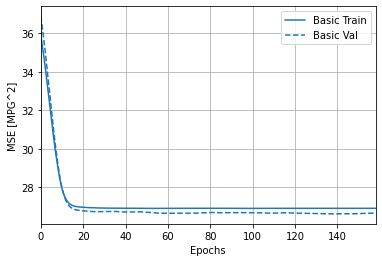

In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE [MPG^2]')

In [0]:
# this is really concerning?
test_labels = pd.to_numeric(test_labels)
loss, mae, mse = model.evaluate(np.asarray(normed_test_data), np.asarray(test_labels), verbose=2)

print("Testing set Mean Sq Error: {:5.2f} MPG".format(mse))

20/20 - 0s - loss: 42.8679 - mae: 3.2248 - mse: 42.8679
Testing set Mean Sq Error: 42.87 MPG


(-20.0, 20.0)

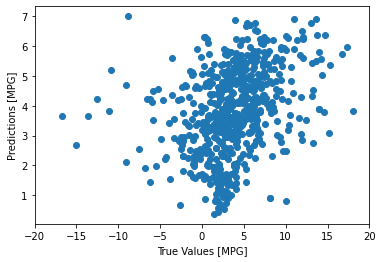

In [0]:
# data is concerning
test_predictions = model.predict(np.asarray(normed_test_data)).flatten()

# a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.xlim(-20,20)


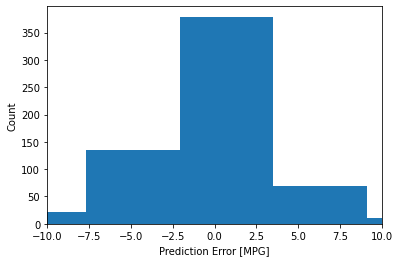

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlim(-10,10)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [0]:

features2 = ['year', 'Tier0','Tier1', 'Tier2','VAA', 'PSNV', 'GE', 'RQ', 'RL', 'CC']


X = df.loc[:, features2]

y = df.GDPgrowth


In [0]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 10
hidden_size = 10
num_classes = 1
num_epochs = 100
batch_size = 10
learning_rate = 0.15

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)


X_train, X_test, y_train, y_test = train_test_split(np.asarray(X).astype(np.float32), np.asarray(y).astype(np.float32), test_size=.10)


X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train).unsqueeze(1)
y_test = torch.tensor(y_test).unsqueeze(1)



train_dataset = Data.TensorDataset(X_train, y_train)

test_dataset = Data.TensorDataset(X_test, y_test)

# Loss and optimizer
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=1, 
                                          shuffle=False)




tensor([[ 1.2285e+00, -6.1017e-01, -8.0105e-01,  ...,  6.2947e-01,
          4.3928e-01,  3.6247e-01],
        [ 2.0131e-01, -6.1017e-01,  1.2480e+00,  ..., -6.0470e-01,
         -8.5515e-04, -3.1233e-01],
        [ 1.0230e+00, -6.1017e-01, -8.0105e-01,  ...,  1.6579e+00,
          2.0770e+00,  2.2761e+00],
        ...,
        [ 8.1761e-01, -6.1017e-01,  1.2480e+00,  ..., -9.0296e-01,
          3.9833e-01,  9.9623e-03],
        [ 1.6393e+00,  1.6384e+00, -8.0105e-01,  ..., -1.4069e+00,
         -1.7102e+00, -1.2188e+00],
        [-1.2367e+00,  1.6384e+00, -8.0105e-01,  ..., -9.3382e-01,
         -8.8112e-01, -1.0677e+00]])
tensor([[ 0.1944],
        [-0.1953],
        [-0.3406],
        ...,
        [-0.4505],
        [-0.0170],
        [ 0.6185]])


In [0]:

#train model

for epoch in range(num_epochs):
  for step, (batch_x,batch_y) in enumerate(train_loader): # for each training step

    #forward pass
    ypred = model(batch_x)
    loss = loss_func(ypred,batch_y)

    #Backpropogation 
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()


#test model
total_loss=0

rounds=0
for step, (batch_x,batch_y) in enumerate(test_loader): # for each training step
  rounds+=1
  #forward pass

  ypred = model(batch_x)
  loss = loss_func(ypred,batch_y)
  total_loss +=loss
  
av_loss = total_loss/rounds




In [0]:
print(av_loss)

tensor(44.0540, grad_fn=<DivBackward0>)


In [0]:
'''
df = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
df
'''

import io
from google.colab import files
uploaded = files.upload()

df3 = pd.read_csv(io.StringIO(uploaded['dataset.csv'].decode('utf-8')))
df3 = df3.drop(['country', 'country_abb'], axis=1)

# # some of the rows have 'NaN' as labels, so gotta drop those
drop_row_indices = []
for i, row in df2.iterrows():
    for j, col in row.iteritems():
        try:
            row[j] = float(col)
        except ValueError:
            # print("ValueError")
            drop_row_indices.append(i)
            continue
        if math.isnan(row[j]):
            drop_row_indices.append(i)

df2 = df2.drop(drop_row_indices, axis=0)

print(df2)

features2 = ['year', 'Tier','VAA', 'PSNV', 'GE', 'RQ', 'RL', 'CC']

X = df2.loc[:, features2]

y = df2.GDPgrowth

Saving dataset.csv to dataset (1).csv
Empty DataFrame
Columns: [year, Tier, VAA, PSNV, GE, RQ, RL, CC, GDPgrowth]
Index: []


In [0]:
df3 = pd.read_csv(io.StringIO(uploaded['dataset.csv'].decode('utf-8')))
df3 = df3.drop(['country', 'country_abb'], axis=1)

df3.head()

# # some of the rows have 'NaN' as labels, so gotta drop those
drop_row_indices = []
for i, row in df3.iterrows():
    for j, col in row.iteritems():
        try:
            row[j] = float(col)
        except ValueError:
            # print("ValueError")
            drop_row_indices.append(i)
            continue
        if math.isnan(row[j]):
            drop_row_indices.append(i)

df3 = df3.drop(drop_row_indices, axis=0)

print(df3)

features3 = ['year', 'Tier','VAA', 'PSNV', 'GE', 'RQ', 'RL', 'CC']

X = df3.loc[:, features2]

y = df3.GDPgrowth

Empty DataFrame
Columns: [year, Tier, VAA, PSNV, GE, RQ, RL, CC, GDPgrowth]
Index: []
